# COVID-19: Daily New Confirmed Cases & Projections

In [20]:
import requests, csv, re, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import geopy.geocoders
from datetime import date, timedelta
from hampel import hampel
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values, missing_values_ratio
from darts.utils.statistics import check_seasonality, plot_acf, extract_trend_and_seasonality, remove_seasonality, remove_trend, plot_residuals_analysis, plot_acf, stationarity_tests, stationarity_test_adf
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.metrics import r2_score, mape, mase, rmse, rmsle, coefficient_of_variation
from darts.models import MovingAverage, KalmanFilter, ExponentialSmoothing, ARIMA, StatsForecastAutoARIMA
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("deep")

import warnings
warnings.filterwarnings("ignore")
# import logging
# logging.disable(logging.CRITICAL)

__author__ = 'Chad Hughes'

## Population Center

In [21]:
# homeLoc = (20.86399628, -156.5689097)        ## Maui, Hawaii, US, POP:   167,417
# homeLoc = (36.21458855, -115.0130241)        ## Clark, Nevada, US, POP: 2,266,715
# homeLoc = (34.59933926, -112.5538588)        ## Yavapai, Arizona
# homeLoc = (38.68278902, -121.90182879999999) ## Yolo, California, US, POP:   220,500
# homeLoc = (38.50735751, -122.33283899999999) ## Napa, California, US, POP:  137,744
homeLoc = (37.42288, -122.32755)               ## San Mateo, California, US, POP:   766,573
# homeLoc = (37.177123, -122.366529)           ## SMC, (this location excludes Alameda Co at 40 miles)
# homeLoc = (37.23104908, -121.6970462)        ## Santa Clara, California, US
# homeLoc = (37.64629437, -121.8929271)        ## Alameda, California, US
# homeLoc = (36.21862405,-121.24133970000001)  ## Monterey, California, US
# homeLoc = (29.88548725, -96.27736949)        ## Austin, Texas, US, POP:  30,032
# homeLoc = (31.31925973, -95.42226208)        ## Houston, Texas
# homeLoc = (34.65329488, -120.0188492)        ## Santa Barbara, California
# homeLoc = (34.30828379, -118.2282411)        ## Los Angeles, California
# homeLoc = (39.01002188, -94.34724536)        ## Jackson, Missouri
# homeLoc = (38.77965956, -120.5233166)        ## El Dorado, California
# homeLoc = (40.7672726,-73.97152637)          ## New York, New York
# homeLoc = (25.6112362,-80.55170587)          ## Miami-Dade, Florida

In [22]:
distTH = 60   ## miles from homeLoc
popMult = 1e5 ## 100k
startDate = pd.Timestamp('20200301')
endNdaysBack = 0

backtestRatio = 0.9
backtestStride = 3
forecastHorizon = 7
predictionDays = 90

geopy.geocoders.options.default_timeout = 15
geolocator = Nominatim(user_agent="revLookup")
location = geolocator.reverse(query=homeLoc, zoom=9)
citations = '''Ground truth: Johns Hopkins University. “COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE).” https://github.com/CSSEGISandData/COVID-19. Accessed {}.
Population center: {}
Copyright © {} {}'''.format(date.today().strftime('%-d %b %Y'), location.address, date.today().year, __author__)

In [23]:
def getCounties(data):
    countyList = []
    covid19Data = []
    populationSum = 0
    for row in data:
        fips = row['FIPS']
        if re.match(r'[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$', fips):  ## match floats
            fips = float(fips)
            combinedKey = row['Combined_Key']
            lat = row['Lat']
            long_ = row['Long_']
            try:
                countyLoc = (float(lat), float(long_))
            except Exception:
                pass
            distance = geodesic(homeLoc, countyLoc).miles
            if distance <= distTH:
                population = populationLookup[fips]
                populationSum += int(population)
                countyList.append(fips)
                print('FIPS:{:7.1f}, {:>30}, POP:{:10,.0f}, {:4,.0f}-miles, {}'.format(fips, combinedKey, float(population), distance, countyLoc))
                covid19Data.append(row)
                if distance <=1:
                    itemList = []
                    for k, v in row.items():
                        itemList.append([k, v])
                    confCaseDays = itemList[11:]
                    k, week2Ago = confCaseDays[-15]
                    k, weekAgo = confCaseDays[-8]
                    k, last = confCaseDays[-1]
                    last = int(float(last))
                    weekAgo = int(float(weekAgo))
                    week2Ago = int(float(week2Ago))
    print('Total population: {:,.0f}'.format(populationSum))
    return(countyList, covid19Data, populationSum)

In [24]:
# FIPS population
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
r = requests.get(url)
if r.status_code != 200:
    # print("Error! Status Code: {}".format(r.status_code))
    raise SystemExit("Error! Status Code: {}".format(r.status_code))

LTable = r.content
data = csv.DictReader(io.StringIO(LTable.decode('utf-8')))

populationLookup = {}
for row in data:
    fips = row['FIPS']
    population = row['Population']
    if re.match(r'[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$', fips):  ## match floats
        populationLookup[float(fips)] = population

## Total Population Area

In [25]:
# Daily cases
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
r = requests.get(url)
if r.status_code != 200:
    # print("Error! Status Code: {}".format(r.status_code))
    raise SystemExit("Error! Status Code: {}".format(r.status_code))

confCasesUS = r.content
data = csv.DictReader(io.StringIO(confCasesUS.decode('utf-8')))
counties, covid19Data, populationSum = getCounties(data)
countyCount = len(counties)

FIPS: 6001.0,        Alameda, California, US, POP: 1,671,329,   28-miles, (37.64629437, -121.8929271)
FIPS: 6013.0,   Contra Costa, California, US, POP: 1,153,526,   41-miles, (37.91923498, -121.9289527)
FIPS: 6041.0,          Marin, California, US, POP:   258,826,   50-miles, (38.07122463, -122.7210631)
FIPS: 6075.0,  San Francisco, California, US, POP:   881,549,   24-miles, (37.75215114, -122.4385672)
FIPS: 6081.0,      San Mateo, California, US, POP:   766,573,    0-miles, (37.4228808, -122.32755459999998)
FIPS: 6085.0,    Santa Clara, California, US, POP: 1,927,852,   37-miles, (37.23104908, -121.6970462)
FIPS: 6087.0,     Santa Cruz, California, US, POP:   273,213,   31-miles, (37.05580291, -122.0066524)
Total population: 6,932,868


In [26]:
countyData = []
for row in covid19Data:
    itemList = []
    for k, v in row.items():
        itemList.append([k, v])
    confCaseDays = itemList[11:]
    df = pd.DataFrame(confCaseDays, columns=['Date', 'Cases'])
    df['Date'] = pd.to_datetime(df['Date'])
    df['Cases'] = pd.to_numeric(df['Cases'], errors='ignore')
    df['Cases'] = (df['Cases'] / populationSum) * popMult ## Cases per <popMult>
    countyData.append(df)
last = pd.DataFrame({'A' : []})  ## Empty DataFrame
for df in countyData:
    if last.empty == True:
        last = df
        # print(df)
    else:
        # print(df)
        df = pd.merge_asof(last, df, on='Date', by='Date', tolerance=pd.Timedelta('3d'))
        last = df
df['Ground Total'] = df.sum(numeric_only=True, axis=1)
df = df[['Date', 'Ground Total']]
df = df.set_index('Date')
endDate = pd.Timestamp(df.iloc[[-1]].index[0].date() - timedelta(endNdaysBack))
series = fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Ground Total', fill_missing_dates=True), fill=0.0).drop_before(startDate - timedelta(1))
numDays = len(series)
df = df.tail(numDays)
series = series.drop_after(endDate)
numDays = len(series)
df = df.head(numDays + 1)

#### Seasonality Test

In [27]:
print('Inspecting seasonality...')
seasonalityDetected = False
for m in range(2, 21):
    is_seasonal, period = check_seasonality(series, m=m, alpha=.05)
    if is_seasonal:
        print('> There is seasonality of order {}.'.format(period))
        seasonalityDetected = True
if seasonalityDetected == False:
    print("> No seasonality detected.")

Inspecting seasonality...
> No seasonality detected.


#### Missing Values

In [28]:
df['Ground Diff'] = df['Ground Total'].diff()
rWindow = 15
df['Rolling'] = df['Ground Total'].rolling(rWindow, min_periods=1, center=True).mean().diff()
df['Rolling'] = df['Rolling'].head(-rWindow)
df['Rolling'].clip(lower=0, inplace=True)

df['Ground Diff'].clip(lower=0, inplace=True)
df['Ground Diff'].replace(0, np.nan, inplace=True)

mv = missing_values_ratio(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Ground Diff'))
print("Missing values: {:0.2f}%".format(mv * 100))

Missing values: 0.98%


In [29]:
series = fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Ground Diff', fill_missing_dates=True), fill=0.0)
df['Ground Diff'] = series.pd_dataframe()
# STL trend
(trend, seasonal) = extract_trend_and_seasonality(ts=series, freq=14, model=ModelMode.ADDITIVE, method='STL')
df['stlTrend'] = trend.pd_dataframe()['0']
df['stlTrend'].clip(lower=0, inplace=True)
df['Trend Diff'] = df['stlTrend']
df.drop('stlTrend', axis=1, inplace=True)
# Naive trend
(trend, seasonal) = extract_trend_and_seasonality(ts=series, freq=14, model=ModelMode.ADDITIVE, method='naive')
df['naiveTrend'] = trend.pd_dataframe()['0']
df['naiveTrend'].clip(lower=0, inplace=True)

#### Outliers

In [30]:
print("Detecting outliers...")
# print("min.: {}".format(df['Trend Diff'].min()))
# print("max.: {}".format(df['Trend Diff'].max()))
# print("nans: {}".format((df['Trend Diff'].isna().sum())))

hempelWindowSize = 7
outliers = hampel(df['Trend Diff'], window_size=hempelWindowSize, n=3, imputation=False)
print("Found {} outliers. Imputing...".format(len(outliers)))
print()
df['New Trend Diff'] = hampel(df['Trend Diff'], window_size=hempelWindowSize, n=3, imputation=True)
# print(df['Trend Diff'].compare(df['New Trend Diff']))
outlierCount = 0
for i in outliers:
    compOne = df['Trend Diff'].iloc[i]
    compTwo = df['New Trend Diff'].iloc[i]
    if compOne != compTwo:
        outlierCount += 1
        print("{} {:12.6f}  -> {:12.6f}".format(df['Trend Diff'].iloc[[i]].index[0].date(), compOne, compTwo))
    else:
        print("{} {:12.6f}  XX {:12.6f}".format(df['Trend Diff'].iloc[[i]].index[0].date(), compOne, compTwo))
df['Trend Diff'] = df['New Trend Diff']
df['Trend Diff'].clip(lower=0, inplace=True)
# print(df['Trend Diff'].compare(df['New Trend Diff']))
df.drop('New Trend Diff', axis=1, inplace=True)
print()
print("Done. Imputed {} outliers.".format(outlierCount))

Detecting outliers...
Found 0 outliers. Imputing...


Done. Imputed 0 outliers.


#### Stationarity Test

In [31]:
# Stationarity test
adfTest = stationarity_test_adf(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Trend Diff'), maxlag=None, regression='c', autolag='AIC')[1]
if adfTest <= 0.05:
    adfResult = "TRUE"
else:
    adfResult = "FALSE"
print("Stationarity test: {} ({:.4f})".format(adfResult, adfTest))

Stationarity test: FALSE (0.0551)


## Weekly Trend

In [32]:
lastWeekMean = df['Trend Diff'].tail(14).head(7).mean()
thisWeekMean = df['Trend Diff'].tail(7).mean()
changePercent = ((thisWeekMean - lastWeekMean) / lastWeekMean) * 100
if changePercent > 0:
    changeDirection = "UP"
else:
    changeDirection = "DOWN"
print(">>> Mean trend this week ({:.1f}) compared to last week ({:.1f}) is {} ({:.1f}%) <<<".format(thisWeekMean, lastWeekMean, changeDirection, changePercent))

>>> Mean trend this week (62.2) compared to last week (48.7) is UP (27.8%) <<<


## Daily Cases

In [33]:
series = fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Trend Diff', fill_missing_dates=True))
transformer = Pipeline([Scaler(MinMaxScaler(feature_range=(1, df['Trend Diff'].min() + df['Trend Diff'].max() + 1))), BoxCox(lmbda=None, optim_method='mle')])
seriesTransformed = transformer.fit_transform(series)
df['Transformed Trend Diff'] = seriesTransformed.pd_dataframe()
df['SWM'] = MovingAverage(window=7, centered=False).filter(fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Trend Diff', fill_missing_dates=True))).pd_series()
df['EWM'] = df['Trend Diff'].ewm(span=7).mean()
kf = KalmanFilter(dim_x=1, kf=None)
kf.fit(fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Transformed Trend Diff', fill_missing_dates=True)))
df['Transformed Smoothed'] = kf.filter(fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Transformed Trend Diff', fill_missing_dates=True))).pd_series()
df['Smoothed'] = transformer.inverse_transform(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Transformed Smoothed')).pd_dataframe()
dfPrint = df.drop(['Transformed Trend Diff', 'Transformed Smoothed'], axis=1)
print(dfPrint.drop('Rolling', axis=1).drop('SWM', axis=1).drop('EWM', axis=1).tail(20))

            Ground Total  Ground Diff  Trend Diff  naiveTrend   Smoothed
Date                                                                    
2022-05-08  17219.266255     1.745309   36.783183   33.487481  35.469181
2022-05-09  17362.583566   143.317311   38.063137   37.752362  36.544313
2022-05-10  17366.290545     3.706980   39.497801   42.105848  37.751949
2022-05-11  17370.358126     4.067581   40.917104   42.208877  39.029271
2022-05-12  17447.671007    77.312881   42.080514   44.141184  40.251634
2022-05-13  17452.272278     4.601270   43.098905   45.938008  41.402207
2022-05-14  17454.277220     2.004942   44.016712   45.752040  42.475760
2022-05-15  17456.065801     1.788582   45.117283   45.626345  43.582379
2022-05-16  17692.461475   236.395673   46.635923   40.448113  44.866848
2022-05-17  17697.755099     5.293625   48.385394   42.656537  46.326037
2022-05-18  17701.490927     3.735828   50.250446   49.838166  47.930002
2022-05-19  17857.126373   155.635446   52.179593  

#### Smoothed Seasonality Test

In [34]:
seriesSmoothed = fill_missing_values(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Transformed Smoothed', fill_missing_dates=True))
print('Inspecting smoothed seasonality...')
seasonalityDetected = False
for m in range(2, 21):
    is_seasonal, period = check_seasonality(series, m=m, alpha=.05)
    if is_seasonal:
        print('> There is seasonality of order {}.'.format(period))
        seasonalityDetected = True
if seasonalityDetected == False:
    print("> No seasonality detected.")

Inspecting smoothed seasonality...
> No seasonality detected.


#### Smoothed Stationarity Test

In [35]:
adfTest = stationarity_test_adf(TimeSeries.from_dataframe(df=df, time_col=None, value_cols='Smoothed'), maxlag=None, regression='c', autolag='AIC')[1]
if adfTest <= 0.05:
    adfResult = "TRUE"
else:
    adfResult = "FALSE"
print("Stationarity test: {} ({:.4f})".format(adfResult, adfTest))

Stationarity test: TRUE (0.0284)


In [36]:
### Auto select ARIMA params
# import pmdarima as pm
# m = pm.AutoARIMA(start_p=0, d=None, start_q=0,
#                     max_p=6, max_d=3, max_q=4,
#                     m=1, seasonal=False, stationary=False,
#                     information_criterion='aic', alpha=0.05)
# aaDF = seriesSmoothed.pd_series()
# print('Auto-selecting ARIMA params...')
# m.fit(aaDF)
# # print(m.summary())
# # print(m.model_.aic())
# # print(dir(m.model_))
# arimaParams = m.model_.get_params()['order']
# p, d, q = arimaParams
# print('ARIMA({}, {}, {}) selected.'.format(p, d, q))

## Backtesting

In [37]:
models = [
    ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.NONE, damped=True),
    StatsForecastAutoARIMA(),
#     ARIMA(p, d, q),
#     ARIMA(1, 1, 2),
#     ARIMA(4, 1, 2),
]
backtests = []
for model in models:
    print('Backtesting {}...'.format(model))
    backtests.append(model.historical_forecasts(seriesSmoothed,
                        start=backtestRatio,
                        forecast_horizon=forecastHorizon,
                        overlap_end=False,
                        stride=backtestStride,
                        # last_points_only=True,
                        # retrain=False,
                        # retrain=True,
                        verbose=True))

Backtesting ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=True, seasonal=SeasonalityMode.NONE, seasonal_periods=None...


  0%|          | 0/26 [00:00<?, ?it/s]

Backtesting Auto-ARIMA-Statsforecasts...


  0%|          | 0/26 [00:00<?, ?it/s]

## Projections

Forecasting...
Plotting...
Forecasting...
Plotting...


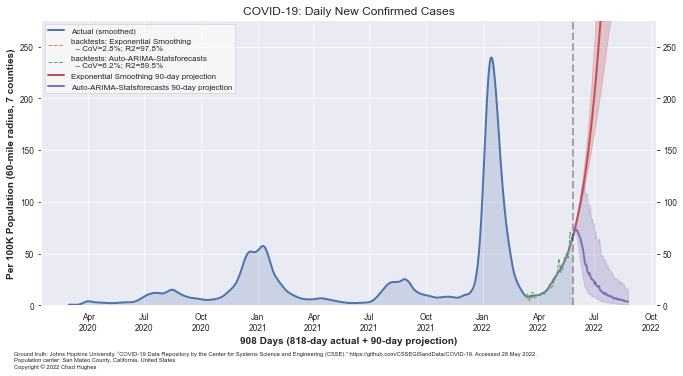

In [38]:
### Set up plot size ratio, ticks, ticklabels
plt.close("all")
sizeRatio = 0.6
fig, ax = plt.subplots()
fig.set_figwidth(16 * sizeRatio)
fig.set_figheight(9 * sizeRatio)
ax.yaxis.set_tick_params(labelright=True)
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))   ## comma separaters
ax.grid(visible=True, which='both', axis='both')

yMax = transformer.inverse_transform(seriesSmoothed).pd_series().max()
ax.set_ylim(0, yMax + (yMax * .15))

transformer.inverse_transform(seriesSmoothed).plot(label='Actual (smoothed)')
for i, m in enumerate(models):
    if re.search(r'NBEATSModel object at ', str(m)):
        m = "N-BEATS"
    elif re.search(r'LGBModel', str(m)):
        m = "LightGBM"
    elif re.search(r'ExponentialSmoothing', str(m)):
        m = "Exponential Smoothing"
    cofv = coefficient_of_variation(backtests[i], seriesSmoothed)
    r2 = r2_score(backtests[i], seriesSmoothed)
    transformer.inverse_transform(backtests[i]).plot(label='backtests: {}\n  – CoV={:.1f}%; R2={:.1f}%'.format(m, cofv, r2 * 100), lw=1, ls='dashed', alpha=0.1)
for i, m in enumerate(models):
    print("Forecasting...")
    m.fit(seriesSmoothed)
    prediction = m.predict(predictionDays, num_samples=25000)
    print("Plotting...")
    if re.search(r'NBEATSModel object at ', str(m)):
        m = "N-BEATS"
    elif re.search(r'LGBModel', str(m)):
        m = "LightGBM"
    elif re.search(r'ExponentialSmoothing', str(m)):
        m = "Exponential Smoothing"
    quantileOffset = .4
    lowQuantile = 0 + quantileOffset
    highQuantile = 1 - quantileOffset
    transformer.inverse_transform(prediction).plot(label='{} {}-day projection'.format(m, predictionDays), low_quantile=lowQuantile, high_quantile=highQuantile)
    
plt.axvline(x=series.time_index[-1].date(), ymin=0, ymax=1, color='k', ls='dashed', lw=2, alpha=0.3)
plt.fill_between(transformer.inverse_transform(seriesSmoothed).pd_series().index, transformer.inverse_transform(seriesSmoothed).pd_series(), label='', lw=2, alpha=0.2)

plt.xlabel(xlabel='{} Days ({}-day actual + {}-day projection)'.format(len(series) + predictionDays, len(series), predictionDays))
plt.ylabel('Per {:d}K Population ({}-mile radius, {} counties)'.format(int(popMult / 1000), distTH, countyCount))
fig.supxlabel(x=0.025, y=0.04, ha='left', va='bottom', weight='light', size='xx-small', t=citations)
plt.legend(prop={'size': 8}, loc='best', frameon=True, fancybox=True, facecolor='#ffffff', framealpha=0.6)

# monthFmt = mdates.DateFormatter("%-d %b %y")
monthFmt = mdates.DateFormatter("%b %Y")
yearFmt = mdates.DateFormatter("%b\n%Y")
nullFmt = mdates.DateFormatter('')

ax.xaxis.set_minor_formatter(monthFmt)
ax.xaxis.set_major_formatter(yearFmt)

months = mdates.MonthLocator()
years = mdates.YearLocator()
autoLoc = mdates.AutoDateLocator()
ax.xaxis.set_minor_locator(autoLoc)
ax.xaxis.set_major_locator(autoLoc)

plt.draw()
ax.set_xticklabels(ax.get_xticklabels(which='both'), rotation=0, ha='center', va='top')
# ax.set_xticklabels(ax.get_xticklabels(minor=True), rotation=0, ha='center', va='top')
# ax.set_xticklabels(ax.get_xticklabels(minor=False), rotation=0, ha='center', va='top')
# plt.setp(ax.get_xticklabels(which='both'), rotation=0, ha='center', va='top')
# plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha='center', va='top')
# plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha='center', va='top')

plt.title('COVID-19: Daily New Confirmed Cases')
plt.tight_layout()
plt.savefig('covidPlot.png', dpi=600, format='png')
plt.show()